In [1]:
import numpy as np
import scipy
import pymc3 as pm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import theano.tensor as tt
from theano.tensor import _shared
import theano

In [2]:
# here is an example of active customer per periode
multi_cohort_data = [[10000, 8000, 6480, 5307, 4391],
                     [10000, 8000, 6480, 5307],
                     [10000, 8000, 6480],
                     [10000, 8000]]

num_periods = max(list(map(len, multi_cohort_data)))

def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

multi_cohort_data_lost = list(map(n_lost, multi_cohort_data))
active_flatten = [i[-1] for i in multi_cohort_data]
active_index = [len(i)-2 for i in multi_cohort_data]
lost_flatten = [j for i in multi_cohort_data_lost for j in i[1:]]
lost_index = [j for i in multi_cohort_data_lost for j in np.arange(len(i[1:]))]

# 2*N data with active customer and churned customer
active_flatten, active_index, lost_flatten, lost_index

([4391, 5307, 6480, 8000],
 [3, 2, 1, 0],
 [2000, 1520, 1173, 916, 2000, 1520, 1173, 2000, 1520, 2000],
 [0, 1, 2, 3, 0, 1, 2, 0, 1, 0])

In [6]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', 0.00001, 1000.0, testval=1)
    beta = pm.Uniform('beta', 0.00001, 1000.0, testval=1)
    p1 = alpha / (alpha + beta)
    s1 = 1. - p1

    def scan_body(t, pt, st):
        pt_1 = ((beta + t - 2) / (alpha + beta + t - 1)) * pt
        st_1 = st - pt_1
        return pt_1, st_1
    (pt, st), _ = theano.scan(
        scan_body,
        sequences=np.arange(2, num_periods),
        outputs_info=[p1, s1])
    pt = tt.concatenate([p1[..., None], pt])
    st = tt.concatenate([s1[..., None], st])
    
    # compute the logp
    # Those who've churned along the way...
    died = tt.log(pt[lost_index]) * lost_flatten

    # and those still active in last period
    still_active = tt.log(st[active_index]) * active_flatten
    retention = pm.Potential('retention', tt.sum(died) + tt.sum(still_active))
    
    trace = pm.sample(cores=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


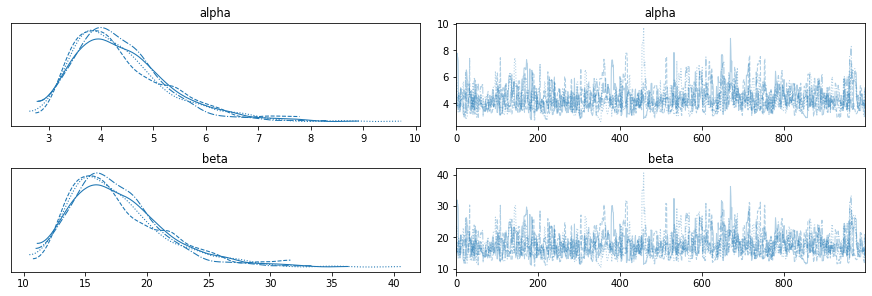

In [10]:
pm.traceplot(trace);

In [11]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,4.392,0.915,2.910,6.079,0.037,0.026,607.0,606.0,623.0,763.0,1.01
beta,17.677,3.835,11.429,24.668,0.155,0.110,609.0,608.0,623.0,794.0,1.01
